--- Step 0: Loading Detailed Data ---
Reading file...

--- Stage 1: Aggregating Customers (440 -> 100) and SNAPPING ---

--- Stage 2: Generating Candidates (100 -> 50) and SNAPPING ---

Success! Files saved:
1. Aggregated_Customers_100.csv (All 100 customers are now real original locations)
2. Aggregated_Demand_Details.csv (Detailed demand mapped to the 100 locations)
3. Aggregated_Candidates_50_Snapped.csv (All 50 warehouses are real original locations)


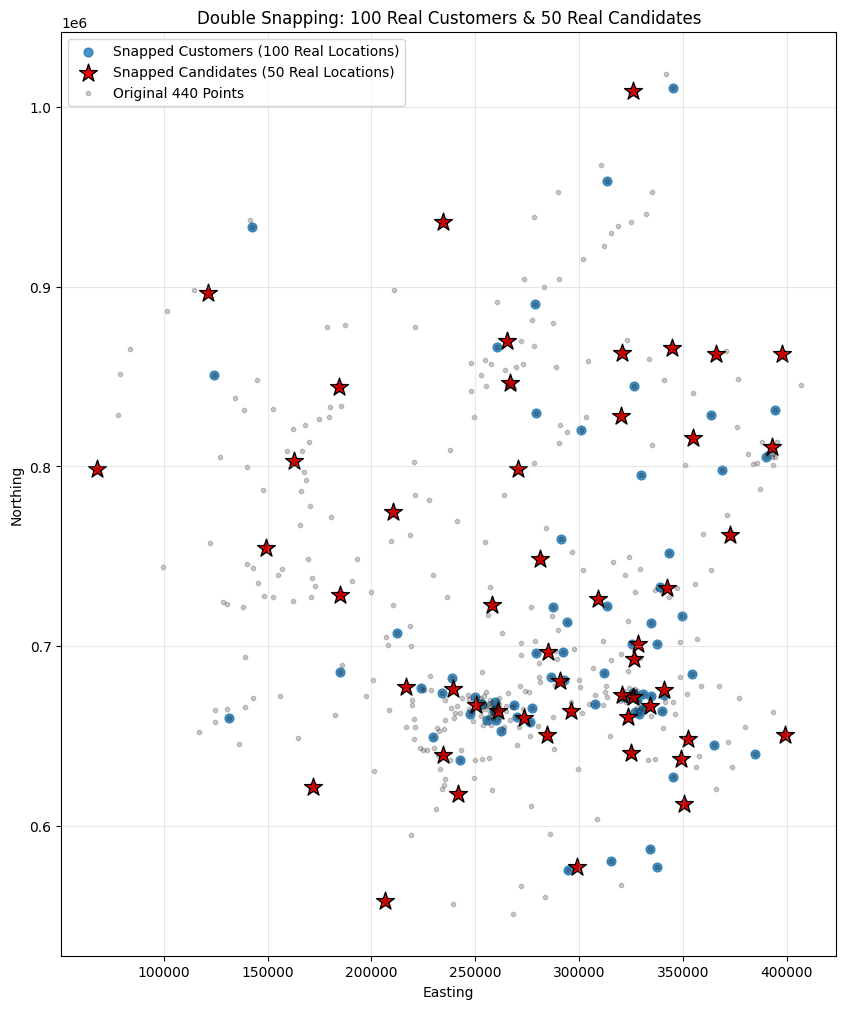

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ==========================================
# 1. Custom Weighted K-Means
# ==========================================
def weighted_kmeans_custom(X, weights, n_clusters, max_iter=100, tol=1e-4, random_state=42):
    n_samples, n_features = X.shape
    rng = np.random.RandomState(random_state)
    random_idx = rng.permutation(n_samples)[:n_clusters]
    centroids = X[random_idx]
    
    for iteration in range(max_iter):
        distances = np.zeros((n_samples, n_clusters))
        for k in range(n_clusters):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.zeros((n_clusters, n_features))
        for k in range(n_clusters):
            mask = (labels == k)
            if np.any(mask):
                new_centroids[k] = np.average(X[mask], axis=0, weights=weights[mask])
            else:
                new_centroids[k] = centroids[k]
        
        if np.sum((centroids - new_centroids)**2) < tol:
            break
        centroids = new_centroids
        
    return labels, centroids

# ==========================================
# 2. Data Parser
# ==========================================
def parse_case_study_data_detailed(file_path):
    print("Reading file...")
    with open(file_path, 'r') as f:
        content = f.read()

    def get_vector(key, dtype=float):
        pattern = re.compile(rf"{key}:\s*\[(.*?)\]", re.DOTALL)
        match = pattern.search(content)
        if match:
            clean_str = match.group(1).replace('"', '').replace('\n', ' ')
            values = clean_str.split()
            if dtype == float: return [float(x) for x in values]
            elif dtype == str: return [str(x) for x in values]
            elif dtype == int: return [int(x) for x in values]
        return []

    ids = get_vector("CustomerId", str)
    easting = get_vector("CustomerEasting", float)
    northing = get_vector("CustomerNorthing", float)

    nb_customers = len(ids)
    
    # Store Detailed Demand Data
    demand_details = np.zeros((nb_customers, 4, 10)) 
    total_demands = np.zeros(nb_customers) 
    
    start_marker = "CustomerDemandPeriods: ["
    start_idx = content.find(start_marker)
    if start_idx != -1:
        pattern = re.compile(r"\((\d+)\s+(\d+)\s+(\d+)\)\s+([\d\s]+)")
        matches = pattern.finditer(content, start_idx)
        for match in matches:
            c_id = int(match.group(1)) - 1 
            p_id = int(match.group(2))     
            s_id = int(match.group(3))     
            
            if s_id == 1 and 1 <= p_id <= 4: 
                vals = [float(x) for x in match.group(4).split()]
                for t in range(len(vals)):
                    if t < 10:
                        demand_details[c_id, p_id-1, t] = vals[t]
                
                total_demands[c_id] += sum(vals)

    df = pd.DataFrame({
        'Original_ID': ids,
        'Easting': easting,
        'Northing': northing,
        'Total_Demand': total_demands
    })
    
    df.loc[df['Total_Demand'] == 0, 'Total_Demand'] = 1.0
    
    return df, demand_details

# ==========================================
# 3. Main Logic (Double Snapping Strategy)
# ==========================================
if __name__ == "__main__":
    file_name = 'CaseStudyData.txt'
    
    N_CUSTOMERS_AGG = 100   # Stage 1: 100 Customers
    N_CANDIDATES_AGG = 50   # Stage 2: 50 Warehouses
    
    try:
        # Step 0: Load Data
        print("--- Step 0: Loading Detailed Data ---")
        df_raw, demand_matrix = parse_case_study_data_detailed(file_name)
        
        # =========================================================
        # Stage 1: Cluster Customers (440 -> 100) and SNAP
        # =========================================================
        print(f"\n--- Stage 1: Aggregating Customers (440 -> {N_CUSTOMERS_AGG}) and SNAPPING ---")
        X_raw = df_raw[['Easting', 'Northing']].values
        W_raw = df_raw['Total_Demand'].values
        labels_1, centroids_1 = weighted_kmeans_custom(X_raw, W_raw, n_clusters=N_CUSTOMERS_AGG)
        
        stage1_data = []      
        detailed_demand_rows = [] 
        
        for i in range(N_CUSTOMERS_AGG):
            mask = (labels_1 == i)
            original_indices = np.where(mask)[0]
            
            total_demand = W_raw[mask].sum()
            cluster_demand_matrix = demand_matrix[original_indices].sum(axis=0)
            
            # --- NEW: Snapping Logic for Customers ---
            theo_cx = centroids_1[i][0]
            theo_cy = centroids_1[i][1]
            
            # Find the nearest original location (from the 440 raw points)
            distances_c = np.sqrt((df_raw['Easting'] - theo_cx)**2 + (df_raw['Northing'] - theo_cy)**2)
            nearest_idx_c = distances_c.idxmin()
            
            snapped_cx = df_raw.loc[nearest_idx_c, 'Easting']
            snapped_cy = df_raw.loc[nearest_idx_c, 'Northing']
            snapped_cid = df_raw.loc[nearest_idx_c, 'Original_ID']
            # -----------------------------------------
            
            row_data = {
                'Agg_Cust_ID': i,
                'Snapped_Original_ID': snapped_cid, # Record the actual original ID
                'Easting': snapped_cx,              # Use the SNAPPED coordinates
                'Northing': snapped_cy,             # Use the SNAPPED coordinates
                'Total_Demand_All_Years': total_demand
            }
            
            for p in range(4):
                row_data[f'Demand_P{p+1}_Total'] = cluster_demand_matrix[p, :].sum()
            stage1_data.append(row_data)
            
            for p in range(4):
                for t in range(10):
                    detailed_demand_rows.append({
                        'Customer': i,        
                        'Product': p + 1,
                        'Period': t + 1,
                        'Demand': cluster_demand_matrix[p, t]
                    })
        
        df_stage1 = pd.DataFrame(stage1_data)
        df_details = pd.DataFrame(detailed_demand_rows)
        
        # =========================================================
        # Stage 2: Cluster Candidates (100 -> 50) and SNAP
        # =========================================================
        print(f"\n--- Stage 2: Generating Candidates ({N_CUSTOMERS_AGG} -> {N_CANDIDATES_AGG}) and SNAPPING ---")
        
        # Notice: X_stage1 now uses the SNAPPED coordinates of the 100 customers
        X_stage1 = df_stage1[['Easting', 'Northing']].values
        W_stage1 = df_stage1['Total_Demand_All_Years'].values
        labels_2, centroids_2 = weighted_kmeans_custom(X_stage1, W_stage1, n_clusters=N_CANDIDATES_AGG)
        
        candidates_final = []
        for c_id in range(N_CANDIDATES_AGG):
            theo_wx = centroids_2[c_id][0]
            theo_wy = centroids_2[c_id][1]
            
            # Snap to the nearest ORIGINAL candidate location (from the 440 raw points)
            distances_w = np.sqrt((df_raw['Easting'] - theo_wx)**2 + (df_raw['Northing'] - theo_wy)**2)
            nearest_idx_w = distances_w.idxmin()
            
            candidates_final.append({
                'Candidate_ID': c_id,
                'Snapped_Original_ID': df_raw.loc[nearest_idx_w, 'Original_ID'],
                'New_Easting': df_raw.loc[nearest_idx_w, 'Easting'],
                'New_Northing': df_raw.loc[nearest_idx_w, 'Northing']
            })
            
        df_candidates_final = pd.DataFrame(candidates_final)
        
        # =========================================================
        # Save Files
        # =========================================================
        df_stage1.to_csv('Aggregated_Customers_100.csv', index=False)
        df_details.to_csv('Aggregated_Demand_Details.csv', index=False)
        df_candidates_final.to_csv('Aggregated_Candidates_50_Snapped.csv', index=False)
        
        print("\nSuccess! Files saved:")
        print("1. Aggregated_Customers_100.csv (All 100 customers are now real original locations)")
        print("2. Aggregated_Demand_Details.csv (Detailed demand mapped to the 100 locations)")
        print("3. Aggregated_Candidates_50_Snapped.csv (All 50 warehouses are real original locations)")
        
        # =========================================================
        # Plotting
        # =========================================================
        plt.figure(figsize=(10, 12))
        
        # Plot 1: 100 Snapped Customers (Blue dots)
        plt.scatter(df_stage1['Easting'], df_stage1['Northing'], 
                   c='tab:blue', s=40, alpha=0.8, label='Snapped Customers (100 Real Locations)')
                   
        # Plot 2: 50 Snapped Candidates (Red stars)
        plt.scatter(df_candidates_final['New_Easting'], df_candidates_final['New_Northing'], 
                   c='red', marker='*', s=180, edgecolors='black', label='Snapped Candidates (50 Real Locations)')
                   
        # Plot 3: 440 Original Background Points (Black dots, light alpha)
        plt.scatter(df_raw['Easting'], df_raw['Northing'], 
                   c='black', s=10, alpha=0.2, label='Original 440 Points')
                   
        plt.title('Double Snapping: 100 Real Customers & 50 Real Candidates')
        plt.xlabel('Easting')
        plt.ylabel('Northing')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    except FileNotFoundError:
        print(f"Error: Could not find {file_name}")